In [1]:
!pip install dnspython -q

In [2]:
!pip install demoji -q
import demoji
demoji.download_codes()


... OK (Got response in 0.15 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import pymongo
import re
import string


In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def myWordCloud(data,title):
  wordcloud = WordCloud(width = 1000, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(' '.join(data)) 
  
  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.title(title)
  plt.show()

In [5]:
def mongoConecta(url, database, collection):
    #print(pymongo.version)
    mongo_url = url
    cliente = pymongo.MongoClient(mongo_url)
    DB = cliente[database]
    DC = DB[collection]
    return DC, cliente

In [6]:
# Mongo Connecet
from setup_mongo import MDB # file with dataconnect ==> url="YOUR URL MONGODB", database='YOUR DATABASE', collection='YOUR COLLECTION'
urlMDB, databaseMDB, collectionMDB = MDB()
dc, c = mongoConecta(url=urlMDB,  database=databaseMDB, collection=collectionMDB)

In [7]:
def cleaningText(txtOriginal, show=False):
  txt = txtOriginal
  txt = txt.lower() # lowercase
  txt = re.sub('@','',txt) # remove @ 
  txt = re.sub('\[.*\]','',txt) # remove contents between brackets
  txt = re.sub('<.*?>+','',txt) # remove contents between less and more signs
  txt = re.sub('https?://\S+|www\.\S+', '', txt) # remove URLs
  txt = re.sub('https', '', txt) # remove URLs
  txt = re.sub(re.escape(string.punctuation), '', txt) # remove punctuation
  txt = re.sub(r'[^a-zA-Z ]+', '', txt) # remove numbers
  txt = re.sub('\n', '', txt) # remove line break
  txt = str(txt).strip()
  if show:
    print('ORIGINAL: ', txtOriginal)
    print('   TEXT CLEANNED: ', txt)
  return txt

def minText(txtOriginal, size=4):
  txt = ''
  for t in txtOriginal.split(' '):
    if len(t)>=size:
      txt += f'{t} '
  return txt

# Exploratory Data Analytics

**Tweets abour COVID 19 - my timeline**

In [8]:
# mongo filtered
filterA = 'covid'
filterB = '02/05'  # month/day
filtro = {'text': {"$regex": filterA}, "data": filterB, 'location': {'$ne': 'null'}}
dataset2 = dc.find(filtro)

In [9]:
df2 = pd.DataFrame(dataset2)
df2.shape

(372, 11)

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   _id         372 non-null    object
 1   created_at  372 non-null    object
 2   id_str      372 non-null    object
 3   text        372 non-null    object
 4   data        372 non-null    object
 5   hora        372 non-null    object
 6   h           372 non-null    object
 7   m           372 non-null    object
 8   keywords    372 non-null    object
 9   language    372 non-null    object
 10  location    236 non-null    object
dtypes: object(11)
memory usage: 32.1+ KB


In [11]:
df2[['data', 'hora', 'location']].describe()

,data,hora,location
count,372,372,236
unique,1,12,182
top,02/05,09:45,"São Paulo, Brasil"
freq,372,51,11


In [12]:
df2.isna().sum()

_id             0
created_at      0
id_str          0
text            0
data            0
hora            0
h               0
m               0
keywords        0
language        0
location      136
dtype: int64

In [13]:
df2[['data', 'hora', 'location', 'language']].head()

,data,hora,location,language
0,02/05,09:35,"São Paulo, Brasil",pt
1,02/05,09:35,"Peso da Régua, Portugal",pt
2,02/05,09:35,None,pt
3,02/05,09:35,None,pt
4,02/05,09:35,None,pt


In [14]:
df2[['data', 'hora', 'location', 'language']].tail()

,data,hora,location,language
367,02/05,09:46,None,pt
368,02/05,09:46,None,pt
369,02/05,09:46,DAVILA,pt
370,02/05,09:46,"Campinas, Brasil",pt
371,02/05,09:46,"Conselheiro Lafaiete, MGBrasil",pt


# Dashboard Top Emojis

In [15]:
def extractEmoji(e):  
  try:
    xyz = demoji.findall(e)
    for em in xyz:
      ems.append(em)
  except:
    pass

In [16]:
# count emojis
ems = [] 
for x in df2.text.values:
  extractEmoji(x)

In [17]:
dfEmoji = pd.DataFrame()
dfEmoji['emoji'] = ems
dfEmoji['cont'] = 1

In [18]:
topEmojis = dfEmoji.groupby('emoji').count().sort_values(by='cont', ascending=False)
topEmojis[:10]

,cont
emoji,
🤫,72
🥲,2
😔,2
🤡,2
♀,1
🤔,1
🥴,1
🥰,1
🤦🏼‍♀️,1


In [19]:
import plotly.express as px
import pandas as pd

limite = 10

d = {"emoji": topEmojis.index[:limite].tolist(),
     "value": topEmojis.values.flatten()[:limite].tolist(),
      }

px.scatter(pd.DataFrame(d), x="emoji", y="value", size='value', color='emoji', 
           template='plotly_white', title=f"Top {limite} Emojis")

# Dashboard Top Words

In [20]:
df2['text2'] = df2.text.apply(lambda x: cleaningText(x))
df2.text2 = df2.text2.apply(lambda x: minText(x))


In [21]:
#count words
cv = CountVectorizer()
matriz = cv.fit_transform(df2.text2)
contaPalavra = pd.DataFrame(cv.get_feature_names(), columns={'Word'})
contaPalavra['Counter'] = matriz.sum(axis=0).tolist()[0]
contaPalavra = contaPalavra.sort_values('Counter', ascending=False).reset_index(drop=True)
contaPalavra[:10] # top 10

,Word,Counter
0,covid,355
1,dengue,74
2,curou,73
3,taoquei,71
4,contra,66
5,para,54
6,vacinar,27
7,como,26
8,variante,23
9,itssrodolfo,22


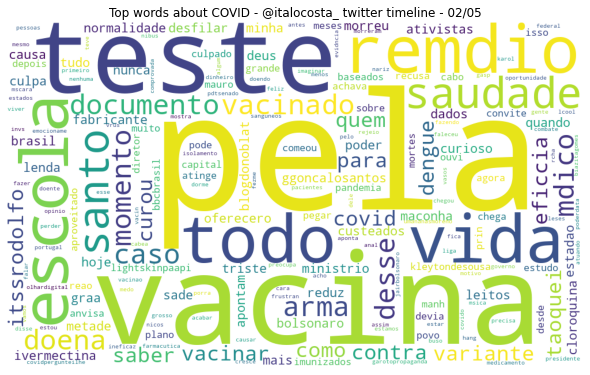

In [22]:
myWordCloud(contaPalavra.Word, f'Top words about COVID - @italocosta_ twitter timeline - {filterB}')

# Sentiment Analysis

In [23]:
import plotly.express as px

!pip install vaderSentiment -q
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
readSentiment = SentimentIntensityAnalyzer()

def getSentimentVader(phrase):
  s = readSentiment.polarity_scores(phrase)
  if s['compound'] <= -0.05:
    sentiment = 0
  elif s['compound'] >= 0.05:
    sentiment = 1
  else:
    sentiment = 2
  return sentiment, s

In [24]:
df2['sentiment'] = df2.text2.apply(lambda x: getSentimentVader(x)[0])
dfS = df2[['sentiment','text2']].groupby('sentiment').count()

In [25]:
colors=['orange', 'Darkblue', 'Darkred']
sentiments = ['Negative', 'Positive', 'Neutral']
px.pie(names=sentiments, values=dfS.text2.values, title='Sentiment Analysis - Tweets - by Vader', 
       color_discrete_sequence=px.colors.sequential.Sunset, width=600)

In [26]:
import textblob
from textblob import TextBlob

def getSentimentTB(txt=''):
    txt = TextBlob(txt)
    txt = txt.sentiment.polarity
    if txt <= -0.05:
      sentiment = 0
    elif txt >= 0.05:
      sentiment = 1
    else:
      sentiment = 2
    return sentiment

df2['sentimentTB'] = df2.text2.apply(lambda x: getSentimentTB(x))
dfS = df2[['sentimentTB','text2']].groupby('sentimentTB').count()

In [27]:
px.pie(names=sentiments, values=dfS.text2.values, title='Sentiment Analysis - Tweets - by TextBlob', 
       color_discrete_sequence=px.colors.sequential.Sunset, width=600)